## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images


## Secondly  Apply a distortion correction to raw images.


In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
%matplotlib inline

import pickle

def calc_mtx_dst_and_save(root_dir,img_size):

    if not os.path.isdir(root_dir):
        print("The folder ",dir,  "doesn't exist")
        return 
    
    full_path = os.path.join(root_dir,'calibration*.jpg') 

    images = glob.glob(full_path)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        assert((img.shape[0]== img_size[1]) and (img.shape[1] ==img_size[0]))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
              
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    
    full_pickle_path = os.path.join(root_dir,'camera_cal_pickle.p')           


    pickle.dump( dist_pickle, open(full_pickle_path, "wb" ) )
    print("dump finished!")
              
def get_mtx_dst(root_dir):
    
    full_pickle_path = os.path.join(root_dir,'camera_cal_pickle.p')           
    dist_pickle = {}
    dist_pickle = pickle.load(open(full_pickle_path,mode= "rb" ) )
    return dist_pickle["mtx"],dist_pickle["dist"]



In [6]:
calc_mtx_dst_and_save("camera_cal",(1280,720))
mtx,dist = get_mtx_dst("camera_cal")

dump finished!


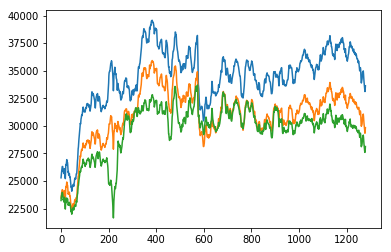

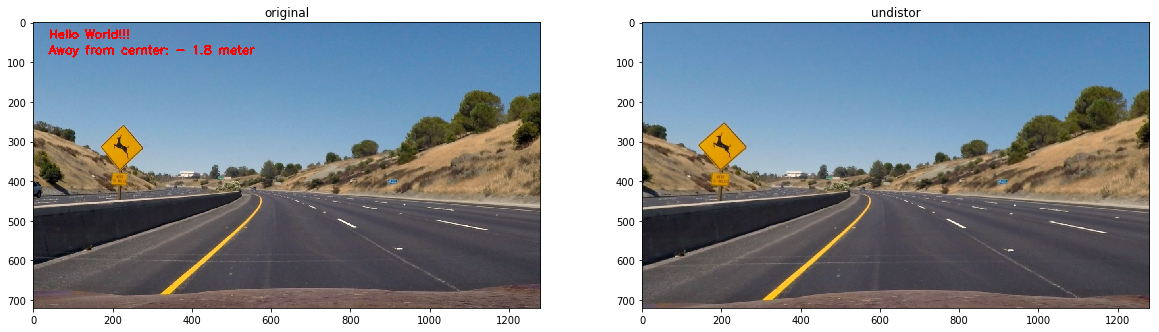

In [7]:
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline


def plot_images(images,titles,cmaps):
    
    assert(len(images) > 1)    
    assert(len(images) == len(titles))    
    assert(len(images) == len(cmaps))
    
    size = len(images) 
    f, ax = plt.subplots(1, size, figsize=(20,10))
    
    for i,image,title,cmap in zip(range(size),images,titles,cmaps):
        ax[i].imshow(image,cmap=cmap)
        ax[i].set_title(title) 

def get_perspective_transform():
    
    img = mpimg.imread("test_images/straight_lines1.jpg")
    img_size = (img.shape[1],img.shape[0])
    bot_width = .76
    mid_width = .08
    height_pct = .62
    bottom_trim = .995
    src = np.float32([[img.shape[1]*(.5 - mid_width/2), img.shape[0]*height_pct], \
                      [img.shape[1]*(.5 + mid_width/2), img.shape[0]*height_pct],\
                      [img.shape[1]*(.5 + bot_width/2), img.shape[0]*bottom_trim], \
                      [0, img.shape[0]*bottom_trim]])
    offset = img_size[0] *.25
    dst= np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
#     img = mpimg.imread("test_images/straight_lines1.jpg")
#     src = np.float32([[203,700],[1076,720],[557,474],[723,474]])
#     img_size = (img.shape[1], img.shape[0])              
#     original_X = 320
#     original_Y = 360
#     extend_X = 640
#     extend_Y = 360
#     dst = np.float32([[original_X, original_Y+extend_Y],[original_X +extend_X, original_Y+extend_Y], 
#                                      [original_X, original_Y], 
#                                      [original_X + extend_X, original_Y]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    return M


M = get_perspective_transform()

def un_distor_demo():

    images = []
    titles = []
    cmaps  = []  
    
    img = mpimg.imread("test_images/test2.jpg")
    undistor_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    cv2.putText(img,"Hello World!!!", (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
    cv2.putText(img,"Away from cernter: - 1.8 meter", (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)

    images.append(img)
    images.append(undistor_img)
    histogram = np.sum(img[img.shape[0]//2:,:],axis=0)
    plt.plot(histogram)
    titles.append("original")
    titles.append("undistor")
    
    cmaps.append("viridis")
    cmaps.append("viridis")
    
    plot_images(images,titles,cmaps)

un_distor_demo()



In [8]:
def normalized(down):

        norm=np.zeros((600,800,3),np.float32)
        norm_rgb=np.zeros((600,800,3),np.uint8)

        b=rgb[:,:,0]
        g=rgb[:,:,1]
        r=rgb[:,:,2]

        sum=b+g+r

        norm[:,:,0]=b/sum*255.0
        norm[:,:,1]=g/sum*255.0
        norm[:,:,2]=r/sum*255.0

        norm_rgb=cv2.convertScaleAbs(norm)
        return norm_rgb


In [9]:
def abs_sobel_thresh(img, orient='x', thresh=(20,100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
#    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_output

def hsv_select(img, thresh=(170, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1

    return binary_output

def color_select(img, sthresh=(170, 255),vthresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary_output = np.zeros_like(s_channel)
    s_binary_output[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary_output = np.zeros_like(v_channel)
    v_binary_output[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary_output ==1) & (v_binary_output ==1)] = 1

    sensitivity = 15

    lower_yellow = np.array([20, 20, 100])
    upper_yelllow = np.array([50, 255, 255])
    lower_white = np.array([0, 0, 255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    
    yellow_selected = cv2.inRange (hsv, lower_yellow, upper_yelllow)
    s_binary_output = np.zeros_like(s_channel)
    s_binary_output[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    white_selected =  cv2.inRange (hsv, lower_white, upper_white)
                                 
    color_selected = yellow_selected | white_selected
       
    return output
    
def hls_sobel_thresh_select(image):
    
    ksize = 3
    hls_binary = hls_select(image, thresh=(20, 255))
    gradx = abs_sobel_thresh(image, orient='x',  thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.1))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

def fine_lane(binary_warped):

    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9#9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100#100
    # Set minimum number of pixels found to recenter window
    minpix = 50#50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return left_fit,right_fit,left_curverad,right_curverad,out_img


def plot_lane(img,left_fit,right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((img, img, img))*255

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)



In [10]:
class Tracker():
    def __init__(self, Mywindow_width, Mywindow_height, Mymargin, My_ym = 1, My_xm = 1, Mysmooth_factor = 15):
        
        self.recent_centers = []
        self.window_width = Mywindow_width
        self.window_height = Mywindow_height
        self.margin = Mymargin
        self.ym_per_pix = My_ym
        self.xm_per_pix = My_xm
        self.smooth_factor = Mysmooth_factor
        
    def find_window_centroids(self, warped):
        
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        # Storing [left,right] pairs
        window_centroids = []
        window = np.ones(window_width)
        
        l_sum = np.sum(warped[int(3 * warped.shape[0] / 4):,:int(warped.shape[1] / 2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum)) - window_width / 2
        
        r_sum = np.sum(warped[int(3 * warped.shape[0] / 4):,int(warped.shape[1] / 2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum)) - window_width / 2 + int(warped.shape[1] / 2)
        
        window_centroids.append((l_center, r_center))
        
        for level in range(1,(int)(warped.shape[0]/window_height)):
           
            image_layer =  np.sum(warped[int(warped.shape[0] - (level + 1) * window_height):int(warped.shape[0] - level * window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            offset = window_width / 2
            
            l_min_index = int(max(l_center + offset - margin, 0))
            l_max_index = int(min(l_center + offset + margin, warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            
            r_min_index = int(max(r_center + offset - margin, 0))
            r_max_index = int(min(r_center + offset + margin, warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
            
            window_centroids.append((l_center,r_center))
            
        self.recent_centers.append(window_centroids)
        
        return np.average(self.recent_centers[-self.smooth_factor:], axis=0)

In [11]:
# def window_mask()
#     output np.zeros_like(img_ref)


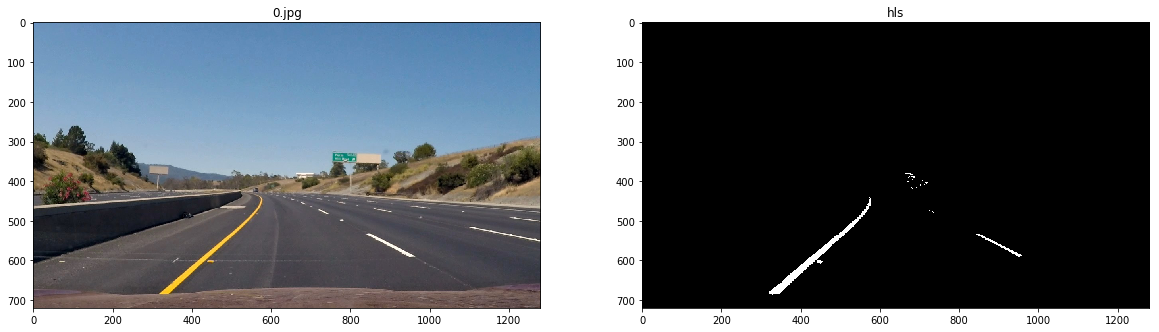

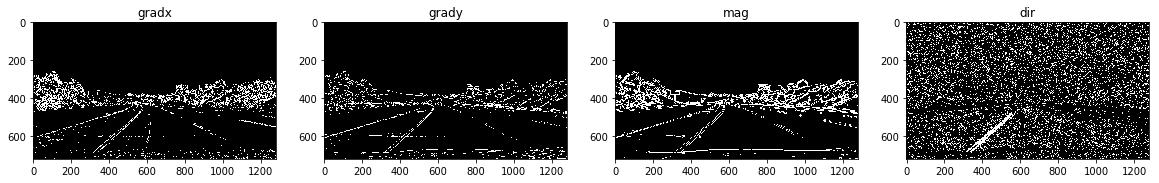

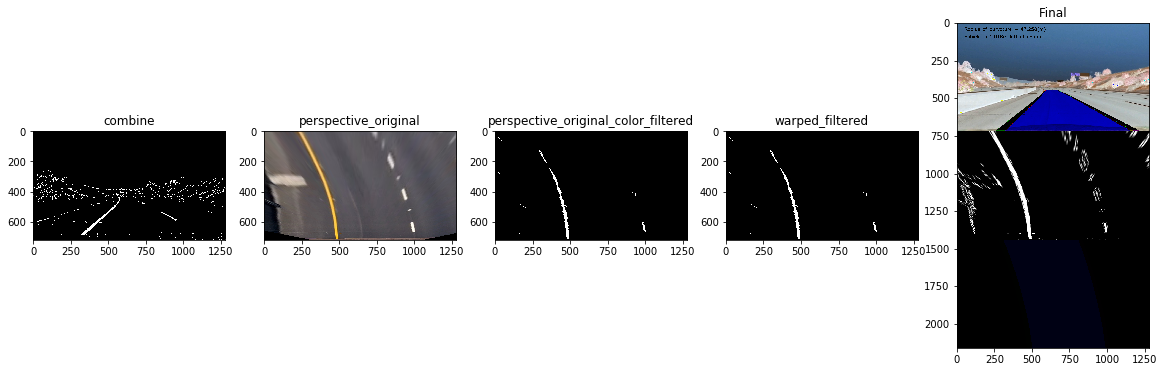

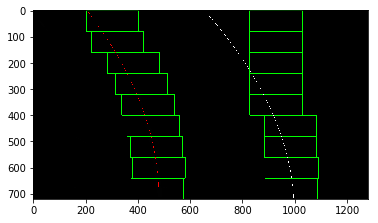

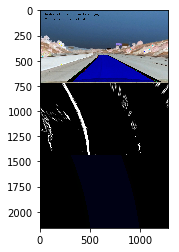

In [12]:

def show_image():

    for name in os.listdir("test_images"):

    
        images.clear()
        titles.clear()
        cmaps.clear()
        full_path = os.path.join("test_images",name)

        img = image = mpimg.imread(full_path)
        #img = image = mpimg.imread("test_images/1.jpg")


        hls_binary = color_select(image,sthresh=(100,255),vthresh=(50,255))

        vertices =get_region_vertices(hls_binary)
        length = hls_binary.shape[1]
        width  = hls_binary.shape[0]
        hls_binary=select_region_of_interest(hls_binary,np.array(vertices))

        gradx = abs_sobel_thresh(image, orient='x',  thresh=(12, 100))
        grady = abs_sobel_thresh(image, orient='y',  thresh=(25, 100))
        mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
        dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
        combined = np.zeros_like(dir_binary)
        combined[(gradx == 1) & (grady == 1) | (hls_binary ==1 )] = 1 

        images.append(image)
        titles.append(name)
        cmaps.append("viridis")

        images.append(hls_binary)
        titles.append("hls")
        cmaps.append("gray")
        plot_images(images,titles,cmaps)

        images.clear()
        titles.clear()
        cmaps.clear()

        images.append(gradx)
        titles.append("gradx")
        cmaps.append("gray")

        images.append(grady)
        titles.append("grady")
        cmaps.append("gray")

        images.append(mag_binary)
        titles.append("mag")
        cmaps.append("gray")

        images.append(dir_binary)
        titles.append("dir")
        cmaps.append("gray")    

        plot_images(images,titles,cmaps)

        images.clear()
        titles.clear()
        cmaps.clear()


        images.append(combined)
        titles.append("combine")
        cmaps.append("gray") 

        img_size = (img.shape[1], img.shape[0])    
        M = get_perspective_transform()

        warped = cv2.warpPerspective(img, M, img_size)    
        images.append(warped)
        titles.append("perspective_original")
        cmaps.append("viridis") 

        sensitivity = 15
        lower_yellow = np.array([20, 20, 100])
        upper_yelllow = np.array([50, 255, 255])
        lower_white = np.array([0, 0, 255-sensitivity])
        upper_white = np.array([255,sensitivity,255])
        #upper_white = np.array([255,255,255])

        hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
        yellow_selected = cv2.inRange (hsv, lower_yellow, upper_yelllow)
        sensitivity = 15
        white_selected =  cv2.inRange (hsv, lower_white, upper_white)

        output = yellow_selected | white_selected
        #output[(white_selected ==1)] = 1


        images.append(output)
        titles.append("perspective_original_color_filtered")
        cmaps.append("gray") 

    #    warped = cv2.warpPerspective(combined, M, img_size)   
        warped = cv2.warpPerspective(combined, M, img_size)    

        images.append(output)
        titles.append("warped_filtered")
        cmaps.append("gray") 



        images.append(process_image3(img))
        titles.append("Final")
        cmaps.append("viridis") 



        plot_images(images,titles,cmaps)


    #     histogram = np.sum(warped[warped.shape[0]//2:,:],axis=0)
    #     plt.plot(histogram)    


        left_fit,right_fit,left_curverad,right_curverad,outputimage = fine_lane(np.array(output))

        warp_zero = np.zeros_like(output).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        outputimage[ploty.astype(int),left_fitx.astype(int)] = [255, 0, 0]
        outputimage[ ploty.astype(int),right_fitx.astype(int)] = [255, 255, 255]

        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        plt.figure()
        plt.imshow(outputimage)
    #     plt.plot(left_fitx, ploty, color='yellow')
    #     plt.plot(right_fitx, ploty, color='red')
    #     plt.xlim(0, 1280)
    #     plt.ylim(720, 0)

    #     final_result= draw_result_back(img,warped,left_fit,right_fit)

        plt.figure()
        plt.imshow(process_image3(img))
        break


def draw_result_back(color_image,binary_warped,left_fit,right_fit):
# Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    from numpy.linalg import inv
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv(M), (color_image.shape[1], color_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(color_image, 1, newwarp, 0.3, 0)
    return result

   

images = []
titles = []
cmaps  = []  



def select_region_of_interest(img,vertices):

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def process_image2(img):
    
    img_size = (img.shape[1], img.shape[0])    
    undistor_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img = undistor_img
    hls_binary = color_select(img,sthresh=(100,255),vthresh=(50,255))
        
    vertices =get_region_vertices(hls_binary)
    length = hls_binary.shape[1]
    width  = hls_binary.shape[0]
    hls_binary=select_region_of_interest(hls_binary,np.array(vertices))

    gradx = abs_sobel_thresh(image, orient='x',  thresh=(12, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(25, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (grady == 1) | (hls_binary ==1 )] = 1 
    

    warped = cv2.warpPerspective(combined, M, img_size)    
    left_fit,right_fit,left_curverad,right_curverad,output_image = fine_lane(np.array(warped))
 

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    away_from_center = ((right_fitx[0] - left_fitx[0])/2 - 640) * xm_per_pix
    
    
    curverad_text = "Left curverad: " + str(left_curverad) + "  Right curverad:" + str(right_curverad)
    center_text = "Away from cernter: " + str(away_from_center) + "Meter"

    cv2.putText(undistor_img,curverad_text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
    cv2.putText(undistor_img,center_text, (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
    
    final_result= draw_result_back(undistor_img,warped,left_fit,right_fit)  
    
    
#         output1 = cv2.resize(np.dstack((warped, warped, warped))*255,(640, 360), interpolation = cv2.INTER_AREA)
#     output2 = cv2.resize(outputimage,(640, 360), interpolation = cv2.INTER_AREA)

#     # Create an array big enough to hold both images next to each other.
#     vis = np.zeros((720, 1280+640, 3))

#     # Copy both images into the composed image.
#     vis[:720, :1280,:] = final_result
#     vis[:360, 1280:1920,:] = output1
#     vis[360:720, 1280:1920,:] = output2
    
    
    
    return final_result

def process_image(img):
    
    
    img_size = (img.shape[1], img.shape[0])    
    undistor_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    image = undistor_img
    hls_binary = hls_select(image, thresh=(90, 255))
    get_region_vertices(hls_binary)
    hls_binary=select_region_of_interest(hls_binary,vertices)
                     
    gradx = abs_sobel_thresh(image, orient='x',  thresh=(12, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(25, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1) & (hls_binary ==1 ) | 
              (mag_binary == 1) & (dir_binary == 1) & (hls_binary ==1))  | 
             (gradx == 1) & (grady == 1) & (mag_binary == 1)
            ] = 1    
    
    warped = cv2.warpPerspective(combined, M, img_size)    
    left_fit,right_fit,left_curverad,right_curverad = fine_lane(np.array(warped))
 

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    away_from_center = ((right_fitx[0] - left_fitx[0])/2 - 640) * 3.5/600
    curverad_text = "Left curverad: " + str(left_curverad) + "  Right curverad:" + str(right_curverad)
    center_text = "Away from cernter: " + str(away_from_center) + "Meter"

    cv2.putText(undistor_img,curverad_text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
    cv2.putText(undistor_img,center_text, (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
    
    final_result= draw_result_back(undistor_img,warped,left_fit,right_fit)
    
    return final_result

def process_image3(img):
    
    img_size = (img.shape[1], img.shape[0])    
    undistor_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    image = img = undistor_img
    hls_binary = color_select(img,sthresh=(100,255),vthresh=(50,255))
        
    vertices =get_region_vertices(hls_binary)
    length = hls_binary.shape[1]
    width  = hls_binary.shape[0]
    hls_binary=select_region_of_interest(hls_binary,np.array(vertices))

    gradx = abs_sobel_thresh(image, orient='x',  thresh=(12, 100))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(25, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (grady == 1) | (hls_binary ==1 )] = 1 
    
    
#     preprocessImage = np.zeros_like(img[:,:,0])
#     gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255))
#     grady = abs_sobel_thresh(img, orient='y', thresh=(25,255))
#     c_binary = color_select(img, sthresh=(100,255), vthresh=(50,255) )
#     preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    
#     warped = cv2.warpPerspective(combined, M, img_size)  
    
#     img = cv2.undistort(img,mtx,dist,None,mtx)
    
#     preprocessImage = np.zeros_like(img[:,:,0])
#     gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255))
#     grady = abs_sobel_thresh(img, orient='y', thresh=(25,255))
#     c_binary = color_select(img, sthresh=(100,255), vthresh=(50,255) )
#     preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

#     image_size = (img.shape[1], img.shape[0])
#     bottom_width = .76
#     mid_width = .08
#     height_pct = .62
#     bottom_trim = .995

#     src = np.float32([ [img.shape[1]*(.5-mid_width/2), img.shape[0]*height_pct], [ img.shape[1]*(.5+mid_width/2), img.shape[0]*height_pct ], [ img.shape[1]*(.5+bottom_width/2), img.shape[0] * bottom_trim], [0, img.shape[0] * bottom_trim]])
#     offset = img_size[0] * .25
#     dst = np.float32([ [offset,0], [image_size[0]-offset, 0], [image_size[0]-offset,image_size[1]], [offset, image_size[1]]])

    
#     M = cv2.getPerspectiveTransform(src,dst)
#     Minv = cv2.getPerspectiveTransform(dst,src)
#     warped = cv2.warpPerspective(preprocessImage, M, image_size, flags=cv2.INTER_LINEAR)
  
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    window_width = 35
    window_height = 80
    curve_centers = Tracker(Mywindow_width = window_width, Mywindow_height = window_height,Mymargin = 25, My_ym = 10/720,My_xm=4/383,Mysmooth_factor = 10)
    window_centroids = curve_centers.find_window_centroids(warped)
    
    leftx = []
    rightx = []
    
    
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    rightx = []
    leftx = []
    
    for level in range(0, len(window_centroids)):
        
        
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
       
    
#     for level in range(0,len(window_centroids)):
#         leftx.append(window_centroids[level][0])
#         rightx.append(window_centroids[level][1])
    
#     left_lane_inds = np.concatenate(left_lane_inds)
#     right_lane_inds = np.concatenate(right_lane_inds)

    yvals = range(0,warped.shape[0])
    righty = lefty = res_yvals =  np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    
    yvals = range(0,warped.shape[0])

    res_yvals = np.arange(warped.shape[0]-(window_height / 2),0,-window_height)
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width / 2, left_fitx[::-1] + window_width / 2), axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width / 2, right_fitx[::-1] + window_width / 2), axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx - window_width / 2, right_fitx[::-1] + window_width / 2), axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx + window_width / 2, right_fitx[::-1] + window_width / 2 - 25), axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    
    cv2.fillPoly(road,[left_lane],color=[0,255,0])
    cv2.fillPoly(road,[right_lane],color=[255,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,236])

    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])
    
    
    from numpy.linalg import inv

    road_warped = cv2.warpPerspective(road, inv(M), img_size,flags=cv2.INTER_LINEAR)  
    road_warped_bkg = cv2.warpPerspective(road_bkg, inv(M), img_size,flags=cv2.INTER_LINEAR)  

    base = cv2.addWeighted(img, 1, road_warped_bkg, -1.0, 0)

    result = cv2.addWeighted(base, 1, road_warped, 1.0, 0)

    
    
    # Meters per pixel in the y dimension.
    ym_per_pix = curve_centers.ym_per_pix
    # Meters per pixel in the x dimension.
    xm_per_pix = curve_centers.xm_per_pix
    
    # Get curvature in terms of meters not pixels
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_per_pix + curve_fit_cr[1]) **2)**1.5) / np.absolute(2 * curve_fit_cr[0])
    
    # Calculate the position of the car on the road.
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1] / 2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    cv2.putText(result, 'Radius of curvature = '+ str(round(curverad, 3)) + '(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
    cv2.putText(result, 'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center ',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    
    color_warp = np.dstack((warped, warped, warped))

#     output1 = cv2.resize(color_warp,(640, 360), interpolation = cv2.INTER_AREA)
#     output2 = cv2.resize(road,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))
    output1 = cv2.resize(color_warp,img_size, interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(road,img_size, interpolation = cv2.INTER_AREA)

    # Copy both images into the composed image.
#     vis[:720, :1280,:] = result
#     vis[:360, 1280:1920,:] = output1
#     vis[360:720, 1280:1920,:] = output2
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)

    vis = np.concatenate((result, output1, output2), axis=0)

    return vis
       
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    from numpy.linalg import inv
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv(M), (color_image.shape[1], color_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    
    
    
    
    
    return img
    
    
    # Extract left and right line pixel positions
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each

    

#     ploty = np.linspace(0, 719, num=720)
#     y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])    
    
    
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
#     left_fit_cr = np.polyfit(np.array(lefty*ym_per_pix,np.int32), np.array(leftx*xm_per_pix,np.int32), 2)
#     right_fit_cr = np.polyfit(np.array(righty*ym_per_pix,np.int32), np.array(rightx*xm_per_pix,np.int32), 2)
#     # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     # Now our radius of curvature is in meters
    
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

#     ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     warp_zero = np.zeros_like(output).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
#     outputimage[ploty.astype(int),left_fitx.astype(int)] = [255, 0, 0]
#     outputimage[ploty.astype(int),right_fitx.astype(int)] = [255, 255, 255]
        
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     away_from_center = ((right_fitx[0] - left_fitx[0])/2 - 640) * xm_per_pix
    
    
#     curverad_text = "Left curverad: " + str(left_curverad) + "  Right curverad:" + str(right_curverad)
#     center_text = "Away from cernter: " + str(away_from_center) + "Meter"

#     cv2.putText(undistor_img,curverad_text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
#     cv2.putText(undistor_img,center_text, (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),4)
    
 
    
#    final_result= draw_result_back(undistor_img,warped,left_fit,right_fit)  
    

#     output1 = cv2.resize(np.dstack((warped, warped, warped))*255,(640, 360), interpolation = cv2.INTER_AREA)
#     output2 = cv2.resize(outputimage,(640, 360), interpolation = cv2.INTER_AREA)

#     # Create an array big enough to hold both images next to each other.
#     vis = np.zeros((720, 1280+640, 3))

#     # Copy both images into the composed image.
#     vis[:720, :1280,:] = img
#     vis[:360, 1280:1920,:] = output1
#     vis[360:720, 1280:1920,:] = output2

    return final_result

def window_mask():
    output

def get_region_vertices(img):
    
    length = img.shape[1]
    width  = img.shape[0]

    vertices = np.array([[(0,width),(length/2.0,width/2.0),(length, width)]], dtype=np.int32)

    return vertices


show_image()

## class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

        
        
        


<function __main__.interactive_mask>

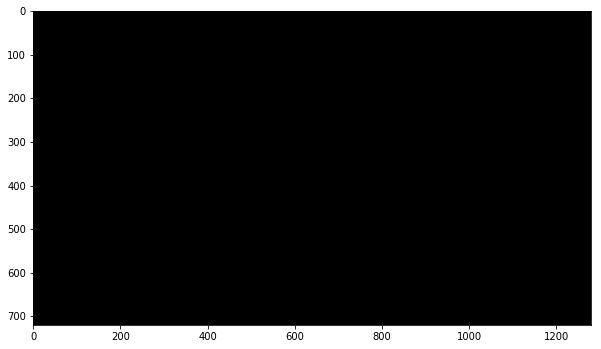

In [13]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

image = mpimg.imread('test_images/test2.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):
    
    img = hls_binary = color_select(image,sthresh=(hls_low,hls_high),vthresh=(bright_low,255))
    
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     hls_binary = clahe.apply(img)
#     kernel = np.ones((5, 5), np.uint8)
#     closing = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    
    vertices =get_region_vertices(hls_binary)
    length = hls_binary.shape[1]
    width  = hls_binary.shape[0]
    hls_binary=select_region_of_interest(hls_binary,np.array(vertices))

    
    
#     gradx = abs_sobel_thresh(image, orient='x',  thresh=(12, 100))
#     grady = abs_sobel_thresh(image, orient='y',  thresh=(25, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(dir_low, dir_high))
    
    combined = np.zeros_like(dir_binary)
    combined[(mag_binary == 1) & (dir_binary == 1) & (hls_binary ==1 )] = 1 

    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')

interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255))

In [14]:


# Process pipeline with aditional information
'''
def process_image_ex(img):
    undist =     cv2.undistort(img, mtx, dist, None, mtx)
# function that returns undistorted image
    img_binary, img_stack = # funcation that returns binary image (img_binary) and image with combination of all thresholds images (img_stack) - it will be displayed near process frame later
    warped, Minv = # function that returns birds-eye view
    lanes, ploty, left_fitx, right_fitx, left_curverad, right_curverad, center_dist = # function that detects lines and lane
    output = # function that warp image back to perspective view

    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composed image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2

    return vis
'''    

'\ndef process_image_ex(img):\n    undist =     cv2.undistort(img, mtx, dist, None, mtx)\n# function that returns undistorted image\n    img_binary, img_stack = # funcation that returns binary image (img_binary) and image with combination of all thresholds images (img_stack) - it will be displayed near process frame later\n    warped, Minv = # function that returns birds-eye view\n    lanes, ploty, left_fitx, right_fitx, left_curverad, right_curverad, center_dist = # function that detects lines and lane\n    output = # function that warp image back to perspective view\n\n    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)\n    output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)\n\n    # Create an array big enough to hold both images next to each other.\n    vis = np.zeros((720, 1280+640, 3))\n\n    # Copy both images into the composed image.\n    vis[:720, :1280,:] = output\n    vis[:360, 1280:1920,:] = output1\n    vis[360:720, 1280:1920,:

In [15]:
import imageio
imageio.plugins.ffmpeg.download()

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

imageio.plugins.ffmpeg.download()

In [19]:



video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,2)
#clip2 = clip1.speedx(0.5
#newclip = clip1.subapply(lambda c:c.speedx(1) , 0,5)
white_clip = clip1.fl_image(process_image3) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:25<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 12s, sys: 4min, total: 13min 12s
Wall time: 8min 27s


In [18]:
video_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:27<00:00,  3.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 7min 26s, sys: 2min 42s, total: 10min 9s
Wall time: 6min 28s


In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{video project_video_output.mp4}">
</video>
""".format(white_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'white_output' is not defined